# CoxPH-Lasso on top EWAS results

```{contents}
```

## Load Data

In [1]:
import pandas as pd

In [2]:
path= 'H:\group\Lamba Share\COMMON.FOLDER\FM_SN_Dx_lasso\Dx_Relapse_70_Lasso_SN_updated'

raw_coefs = pd.read_csv(path + '\LASSO_Results_70%_SPilt_C_Beta_updated.csv', index_col=0)\
    .sort_index()

df = pd.read_excel(path + '\LASSO_Results_70_Spilt_C_Input.xlsx', index_col=0)\
    .sort_index()

## Perform multivariate CoxPH-Lasso

Here we will run on 167 CpGs that were selected from EWAS risk-adjusted OS at 1*10e-6 significance:

In [3]:
def set_cutoff(coefs, threshold):
    """
    Set feature inclusion threshold (only features present in [threshold]% of loops will be taken).

    Parameters:
    ----------
    coefs: object
        A dataframe containing the raw calculated coefficients. 
    threshold: float, default= 0.8
        Feature inclusion threshold (only features present in [threshold]% of loops will be taken)

    Returns:
    --------
    A dataframe containing the mean, non-zero calculated coefficients.

    """
    # Set feature inclusion threshold (only features present in 80% of loops will be taken)
    coefs2 = coefs[coefs['nonzero_freq'] > threshold].replace(
        0, np.NaN).drop(columns=['nonzero_count', 'nonzero_freq'])

    # Get the mean values of selected coefficients, ignoring 0s
    coef_mean = coefs2.mean(axis=1, skipna=True).sort_values(ascending=False)
    return (coef_mean)


def plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.85, savefig=False, figsize=(12,6)):
    
    sns.set_theme(style='white')

    # Larger figure size
    fig, ax = plt.subplots(figsize=figsize)

    # Sorting the raw_coefs DataFrame by 'nonzero_freq'
    raw_coefs = raw_coefs.sort_values('nonzero_freq', ascending=False)

    # Plotting with a more pleasing color palette
    sns.barplot(x=raw_coefs.index, y=raw_coefs['nonzero_freq'], palette='viridis', ax=ax)

    # Adding y line
    plt.axhline(threshold, linestyle="--", color="red", label=f"Threshold for selection ({int(threshold*100)}%)",
                alpha=0.5)

    # Adding labels and title
    ax.set_xlabel("Genes, n=" + str(len(raw_coefs)), fontsize=11)
    ax.set_ylabel("Non-zero Coefficient Frequency", fontsize=11)

    plt.title(f'{len(mean_coefs)} Genes maintain significance in >{int(threshold*100)}% of model loops',
              pad=20)

    # Add xticks rotation
    plt.xticks(rotation=90)

    # Legend
    plt.legend()

    # Tight layout
    plt.tight_layout()

    # Saving the figure
    if savefig == True:
        plt.savefig(path + '/Non_zero_freq.png',
                    bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()


def generate_coxph_score(coef_mean, x, df, score_name, train_test='train'):
    """Generates a dataframe with score/Cox PH predictions

    Parameters:
    ----------
    coef_mean: object
        List of mean coeficients from CoxPH fit.
        Note: this value has to be a pandas series.
    df: object
        Dataframe to add your results to.
    x: object
        A dataframe of variables/features that will be used to calculate the score.
    score_name: 
        Name of your score/prediction column.
    train_test: str | float, default = 'train' 
        Use 'train' or float between 0 and 1 for cutoff percentile.
        If test, use pre-determined number for binary threshold/cutoff.
    cutoff: float, default=0.5
        Cutoff only matters if 'train' is selected in 'train_test' arg.
        cutoff is within (0,1) and defines cutoff percentile for
        categorical score.

    Returns:
    --------
        A dataframe with calculated quantitative and categorical score/model predictions
        and the value of the cutoff on the continuous variable.

    """

    # Calculate score in test(validation) data
    b = np.arange(len(coef_mean))
    df2 = pd.DataFrame()
    coef_mean = coef_mean.squeeze()  # Transforms coefs into pd.Series if pd.DataFrame

    for i in b:
        df2['coef_' + str(i)] = x[coef_mean.index[i]
                                  ].apply(lambda x: x * coef_mean[i])

    df3 = df2.iloc[:, (df2.shape[1] - coef_mean.shape[0]):df2.shape[1]]

    # Save calculated score as a separate column of the original dataframe
    df[score_name] = df3.sum(axis=1)

    # Determine train
    if train_test == 'train':
        
        from sklearn.tree import DecisionTreeRegressor

        X = df[[score_name]]
        y = df['efs.time']

        # Build a decision tree
        tree = DecisionTreeRegressor(max_depth=1)
        tree.fit(X, y)

        # Get the threshold value for split
        i = tree.tree_.threshold[0]

    else:
        i = train_test

    print(f'Continuous score cut at the value of {round(i,4)}')

    # Binarize score
    df[score_name + ' Categorical'] = pd.cut(df[score_name],
                                             bins=[-np.inf, i, np.inf],
                                             labels=['Low', 'High'])

    df[score_name + '_cat_bin'] = pd.cut(df[score_name],
                                         bins=[-np.inf, i, np.inf],
                                         labels=[0, 1])

    return (df, i)

In [4]:
# change column `non_zero_frequency` to `nonzero_freq`
raw_coefs = raw_coefs.rename(columns={'non_zero_frequency': 'nonzero_freq', 'non_zero_counts': 'nonzero_count'})

### Set Threshold

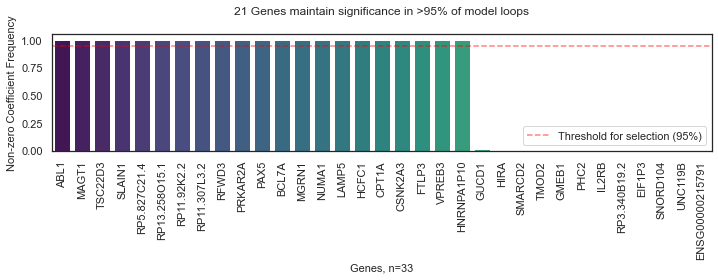

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='white')

mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.95)
                                
plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.95, savefig=True, figsize=(10,4))


## Generate Model Results

### Discovery Dataset

In [6]:
df[['efs.time', 'os.time', 'efs.evnt', 'os.evnt']].describe().round(2)

,efs.time,os.time,efs.evnt,os.evnt
count,1035.00,1035.00,1035.00,1035.00
mean,2.64,3.49,0.53,0.35
std,2.27,2.22,0.50,0.48
min,0.00,0.00,0.00,0.00
25%,0.70,1.38,0.00,0.00
50%,1.75,3.41,1.00,0.00
75%,4.47,5.20,1.00,1.00
max,9.95,11.02,1.00,1.00


In [8]:
score_name = 'Relapse Score'

# Find columns in `df` that are in `mean_coefs.index`
cols_of_interest = df.columns[df.columns.isin(mean_coefs.index)]
gene_expression_matrix = df[cols_of_interest]

In [13]:
#sort column order by mean_coefs
gene_expression_matrix = gene_expression_matrix[mean_coefs.index]

In [15]:
df, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=gene_expression_matrix,
                                        df=df,
                                        score_name=score_name,
                                        train_test="train")

Continuous score cut at the value of -1.7388


## Kaplan-Meier Plots

In [16]:
def draw_kaplan_meier(scorename, df, save_plot=False,
                      add_risk_counts=False, save_survival_table=False,
                      trialname=None, show_ci=False):
    """
    Returns a Kaplan-Meier plot with:

        1. Hazard Ratio
        2. P-value
        3. Risk counts
        4. Survival table

    Parameters:
    ----------
    scorename: str
        Name of your model (and a column in df).
    df: object
        A dataframe containing:
            1. Continuous predictions of Cox Regression model under "scorename".
            2. efs/os information in the format of "efs.time" and "efs.evnt".
    save_plot: bool, default=False
        Set to True if you wish to save the plot.It will be saved under "../Figures/ForestPlot/"
    trialname: str
        Name of your clinical trial or dataset.
    scorename: str
        Name of your model.

    Returns:
    --------
        A magnificent double kaplan-meier figure.

    """
    # Import libraries for Kaplan Meier
    from lifelines.plotting import add_at_risk_counts
    from lifelines import KaplanMeierFitter
    from lifelines import CoxPHFitter

    # Set up the matplotlib figure
    sns.set_theme(style='white')
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    # Define survival curve categories
    groups = df[scorename + ' Categorical']
    ix = (groups == 'High')

    # Fit the Kaplan Meier to each category of groups (kmf1 and kmf2)
    def surv_curves(i, t, e):

        T = df[t]
        E = df[e]
        kmf1 = KaplanMeierFitter()
        kmf1.fit(T[~ix], E[~ix], label='Low-' + scorename + ', n=' +
                 str(len(df[df[scorename + ' Categorical'].isin(['Low'])])))
        ax = kmf1.plot_survival_function(
            ax=i, show_censors=True, ci_show=show_ci)

        kmf2 = KaplanMeierFitter()
        kmf2.fit(T[ix], E[ix], label='High-' + scorename + ', n=' +
                 str(len(df[df[scorename + ' Categorical'].isin(['High'])])))
        ax = kmf2.plot_survival_function(
            ax=i, show_censors=True, ci_show=show_ci)

        # Calculate Hazard Ratio (HZ) and p-value (p)
        X_CPH = df[[scorename + '_cat_bin', t, e]]
        cph = CoxPHFitter()
        HZ = cph.fit(X_CPH, t, event_col=e)
        hz = HZ.hazard_ratios_[0]
        p = HZ.summary['p'][0]

        # Annotate HZ and p
        i.annotate(f'Hazard Ratio: {hz:.4f}\np-value: {p:.2e}',
                   xy=(9.75, 0.085), xycoords='data',
                   ha='right', va='center', fontsize=11,
                   bbox={'boxstyle': 'round', 'facecolor': 'none',
                         'edgecolor': 'lightgray'})

        # Add risk counts below the graph
        if add_risk_counts == True:
            add_at_risk_counts(kmf1, kmf2, ax=i)

        # Save Survival Function Table
        if save_survival_table == True:
            surv1 = kmf1.survival_function_.join(kmf1.confidence_interval_)
            surv2 = kmf2.survival_function_.join(kmf2.confidence_interval_)
            surv3 = surv1.join(surv2, how='outer')
            surv3.to_csv('../Figures/Kaplan_Meiers/KM_OS_SurvivalTable_' +
                         scorename + '_' + trialname + '_' + str(len(df)) + '.csv')

        i.set_ylim(0, 1)
        i.set_ylabel("est. probability of survival $\hat{S}(t)$")

    surv_curves(i=ax[0], t='efs.time', e='efs.evnt')
    surv_curves(i=ax[1], t='os.time', e='os.evnt')

    ax[0].set_title('Event-Free Survival', loc='left',
                    pad=10, fontweight='bold')
    ax[1].set_title('Overall Survival', loc='left', pad=10, fontweight='bold')
    # Define Plot Specs
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.suptitle("Kaplan-Meiers of " + scorename + " in " + trialname + ", n=" + str(len(df)),
                 fontsize='medium', y=0.94,
                 fontweight='bold')
    plt.xlim(0, 10)
    plt.xlabel("time $t$ (years)")

    # Save plot figure
    if save_plot == True:
        plt.savefig(path + '/Kaplan-meier_' + scorename + '_' + trialname + '_' + str(len(df)) + '.png',
                    bbox_inches='tight', dpi=300)

    return (plt.show())


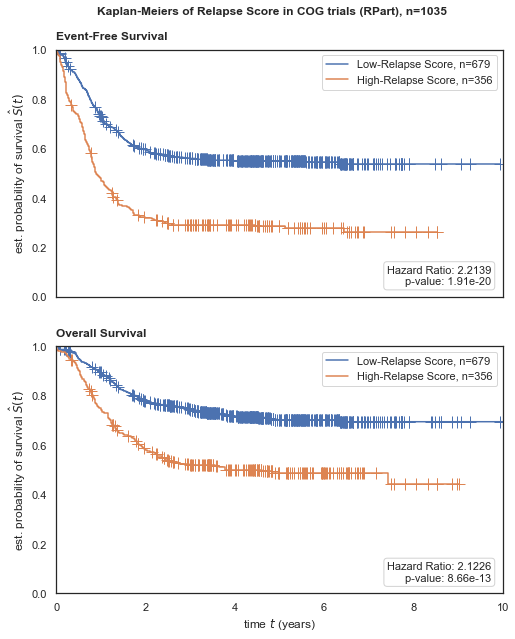

In [17]:
draw_kaplan_meier(scorename=score_name,
                        df=df,
                        save_plot=True,
                        add_risk_counts=False,
                        trialname='COG trials (RPart)')

## Plot R-Part Results

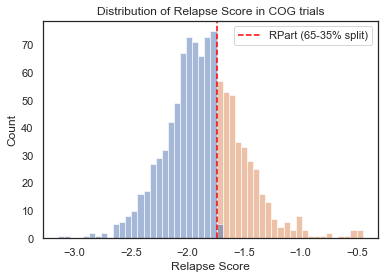

In [18]:
sns.histplot(data=df,x=score_name, bins=50, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='red', linestyle='--')

# add legend
plt.legend({'RPart (65-35% split)':threshold})
plt.title('Distribution of ' + score_name + ' in COG trials')

plt.savefig(path + '/Distribution_' + score_name + '_' + str(len(df)) + '.png',
                    bbox_inches='tight', dpi=300)
                    


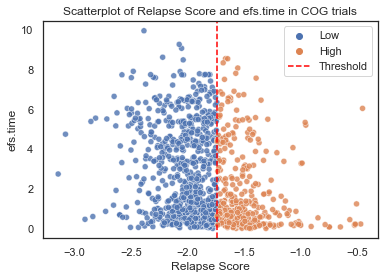

In [19]:
# create scatterplot
sns.scatterplot(data=df, x=score_name, y='efs.time', hue=score_name + ' Categorical', alpha=0.8)

# add title
plt.title('Scatterplot of ' + score_name + ' and efs.time in COG trials')

# add vertical line at threshold
plt.axvline(threshold ,color='red', linestyle='--', label='Threshold')
plt.legend()

# save plot as png
plt.savefig(path + '/Scatterplot_' + score_name + '_efs.time_' + str(len(df)) + '.png',
                    bbox_inches='tight', dpi=300)

plt.show()


In [20]:
mean_coefs

Gene
BCL7A            0.185345
CPT1A            0.139946
TSC22D3          0.109935
LAMP5            0.044749
RP5.827C21.4     0.018669
HNRNPA1P10      -0.003546
RP11.307L3.2    -0.019626
RP11.92K2.2     -0.025369
PRKAR2A         -0.039751
RFWD3           -0.041338
SLAIN1          -0.044318
CSNK2A3         -0.052791
RP13.258O15.1   -0.056595
ABL1            -0.066750
VPREB3          -0.080510
PAX5            -0.091643
HCFC1           -0.093234
NUMA1           -0.103723
FTLP3           -0.117952
MAGT1           -0.158862
MGRN1           -0.174565
dtype: float64

In [21]:
# Save df
df.to_csv(path+'\LASSO_Relapse_Score_70split_c_Unadjusted_Risk' + '_' + str(len(df)) + '.csv')

## Validation

In [22]:
path= 'H:\group\Lamba Share\COMMON.FOLDER\FM_SN_Dx_lasso\Dx_Relapse_30_Validation'

df_validation = pd.read_excel(path + '\Dx_Relapse_30_Rand26_C_Validation.xlsx', index_col=0)\
    .sort_index()

## Apply Model to Test Dataset

In [23]:
score_name = 'Relapse Score'
# Find columns in `df_validation` that are in `mean_coefs.index`
cols_of_interest = df_validation.columns[df_validation.columns.isin(mean_coefs.index)]
gene_expression_matrix_validation = df_validation[cols_of_interest]
#sort column order by mean_coefs
gene_expression_matrix_validation = gene_expression_matrix_validation[mean_coefs.index]

In [26]:
df_validation2, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=gene_expression_matrix_validation,
                                        df=df_validation,
                                        score_name=score_name,
                                        train_test=-1.7388)

Continuous score cut at the value of -1.7388


## Kaplan-Meier Plots

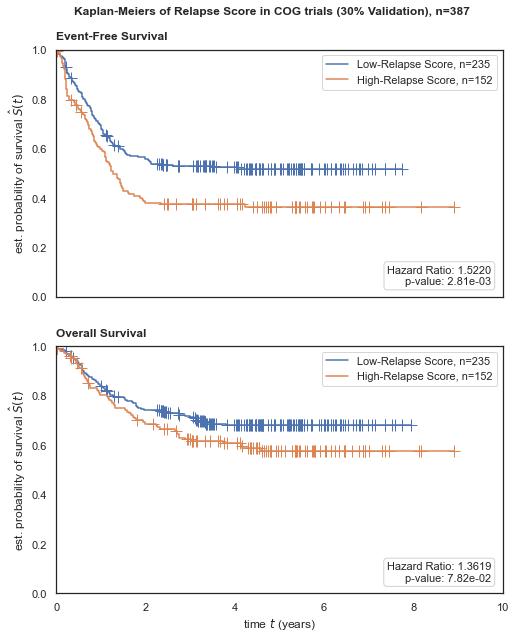

In [27]:
draw_kaplan_meier(scorename=score_name,
                        df=df_validation2,
                        save_plot=True,
                        add_risk_counts=False,
                        trialname='COG trials (30% Validation)')

## Plot R-Part Results

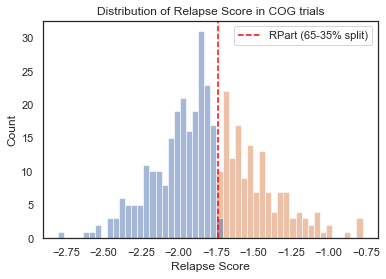

In [28]:
sns.histplot(data=df_validation,x=score_name, bins=50, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='red', linestyle='--')

# add legend
plt.legend({'RPart (65-35% split)':threshold})
plt.title('Distribution of ' + score_name + ' in COG trials')

plt.savefig(path + '/Distribution_' + score_name + '_' + str(len(df_validation)) + '.png',
                    bbox_inches='tight', dpi=300)
                    


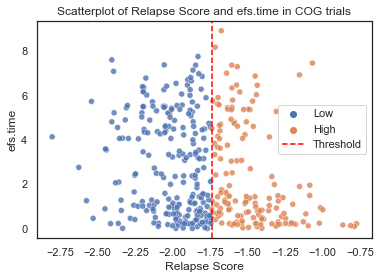

In [29]:
# create scatterplot
sns.scatterplot(data=df_validation, x=score_name, y='efs.time', hue=score_name + ' Categorical', alpha=0.8)

# add title
plt.title('Scatterplot of ' + score_name + ' and efs.time in COG trials')

# add vertical line at threshold
plt.axvline(threshold ,color='red', linestyle='--', label='Threshold')
plt.legend()

# save plot as png
plt.savefig(path + '/Scatterplot_' + score_name + '_efs.time_' + str(len(df_validation)) + '.png',
                    bbox_inches='tight', dpi=300)

plt.show()


In [30]:
# Save df
df_validation.to_csv(path+'\LASSO_Relapse_Score_70split_c_Unadjusted_Risk' + '_' + str(len(df)) + '.csv')

## Watermark

In [11]:
%load_ext watermark

In [12]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,statannotations -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

pandas         : 2.0.1
seaborn        : 0.11.2
matplotlib     : 3.7.1
tableone       : 0.7.12
sklearn        : 1.2.2
lifelines      : 0.27.7
statannotations: 0.5.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

